# Edge and Corner Detection in Unorganized Point Clouds

In [1]:
!pip install pyntcloud
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
 

In [2]:
%%time
from pyntcloud import PyntCloud
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.linear_model import RANSACRegressor
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from sklearn.cluster import DBSCAN
from collections import deque
from itertools import combinations

CPU times: user 3.51 s, sys: 404 ms, total: 3.92 s
Wall time: 6.63 s


In [4]:
%%time
file_path = "/content/drive/MyDrive/Edge and Corner Detection in Unorganized Point Clouds/ArtificialPointClouds/Cube30KSharpEdge.pcd"
pcd = PyntCloud.from_file(file_path)

CPU times: user 20.3 ms, sys: 884 µs, total: 21.2 ms
Wall time: 23.2 ms


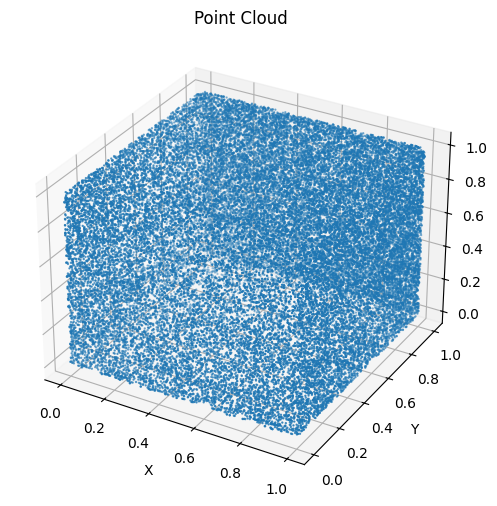

CPU times: user 1.67 s, sys: 2.62 ms, total: 1.68 s
Wall time: 1.48 s


In [5]:
%%time
df = pcd.points

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], s=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Point Cloud")
plt.show()

## 1. Edge Points Extraction

In [6]:
%%time
def detect_edges(pcd: PyntCloud, k_n: int = 50, thresh: float = 0.03):
    kdtree_id = pcd.add_structure("kdtree")
    k_neighbors = pcd.get_neighbors(k=k_n, kdtree=kdtree_id)

    pcd.add_scalar_field("eigen_values", k_neighbors=k_neighbors)

    x = pcd.points['x'].values
    y = pcd.points['y'].values
    z = pcd.points['z'].values

    e1 = pcd.points[f'e3({k_n+1})'].values
    e2 = pcd.points[f'e2({k_n+1})'].values
    e3 = pcd.points[f'e1({k_n+1})'].values

    sum_ev = e1 + e2 + e3
    sigma = e1 / sum_ev
    sigma_value = sigma.copy()

    edge_mask = sigma > thresh

    pcd_np = np.zeros((len(x), 6))
    pcd_np[:, 0] = x
    pcd_np[:, 1] = y
    pcd_np[:, 2] = z

    sigma_value[sigma_value < thresh] = 0
    sigma_value[sigma_value >= thresh] = 255
    pcd_np[:, 3] = sigma_value

    df_full = pd.DataFrame(pcd_np, columns=['x','y','z','red','green','blue'])
    df_full['red'] = df_full['red'].astype(np.uint8)
    pcd_points = PyntCloud(df_full)

    edge_np = pcd_np[edge_mask]
    df_edges = pd.DataFrame(edge_np, columns=['x','y','z','red','green','blue'])
    edge_points = PyntCloud(df_edges)

    return pcd_points, edge_points

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.5 µs


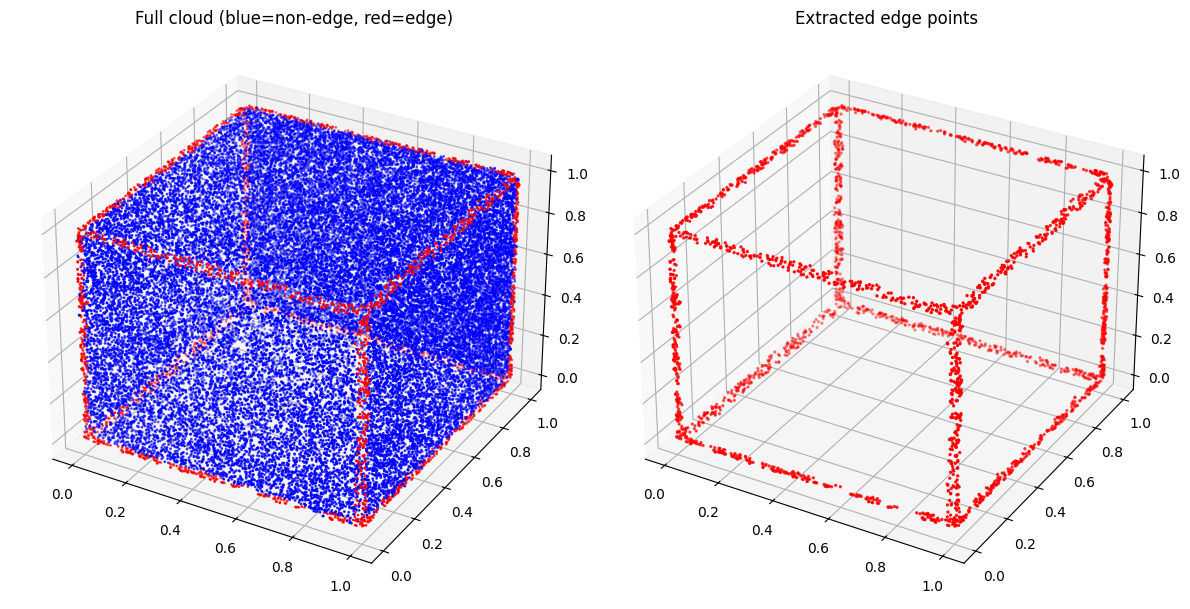

CPU times: user 2.57 s, sys: 27.7 ms, total: 2.6 s
Wall time: 2.2 s


In [7]:
%%time
full_cloud, edges = detect_edges(pcd, k_n=50, thresh=0.06)

reds = full_cloud.points['red'].values
colors_full = np.where(reds > 0, 'red', 'blue')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

ax1.scatter(full_cloud.points['x'], full_cloud.points['y'], full_cloud.points['z'],
            c=colors_full, s=1)
ax1.set_title('Full cloud (blue=non-edge, red=edge)')

ax2.scatter(edges.points['x'], edges.points['y'], edges.points['z'],
            c='red', s=2)
ax2.set_title('Extracted edge points')

plt.tight_layout()
plt.show()

## 2. Corner Detection

In [12]:
%%time
def detect_harris_corners(edge_cloud: PyntCloud,
                          normal_k: int = 20,
                          radius: float = 0.05,
                          k: float = 0.04,
                          min_neighbors: int = 10,
                          thresh: float = 0.01,
                          non_max_radius: float = 0.05):
    pts = edge_cloud.points
    xyz = np.vstack((pts['x'], pts['y'], pts['z'])).T
    tree = KDTree(xyz)
    N = len(xyz)

    normals = np.zeros_like(xyz)
    for i, p in enumerate(xyz):
        dist, idx = tree.query(p, k=normal_k)
        neigh = xyz[idx] - p
        cov = neigh.T.dot(neigh)
        _, vecs = np.linalg.eigh(cov)
        normals[i] = vecs[:, 0]

    R = np.zeros(N)
    for i, p in enumerate(xyz):
        idx = tree.query_ball_point(p, radius)
        if len(idx) < min_neighbors:
            continue
        diffs = normals[idx] - normals[i]
        H = diffs.T.dot(diffs)
        R[i] = np.linalg.det(H) - k * (np.trace(H) ** 2)

    R[R < 0] = 0
    if R.max() <= 0:
        return np.empty((0,3))
    R = R / R.max()
    cand = np.where(R >= thresh)[0]

    keep = []
    for i in cand:
        nbr = tree.query_ball_point(xyz[i], non_max_radius)
        if all(R[i] >= R[j] for j in nbr):
            keep.append(i)

    corners = xyz[keep]
    return corners

def find_extreme_corners(corners):
    extreme_corners = []
    for x in [np.min(corners[:, 0]), np.max(corners[:, 0])]:
        for y in [np.min(corners[:, 1]), np.max(corners[:, 1])]:
            for z in [np.min(corners[:, 2]), np.max(corners[:, 2])]:
                target = np.array([x, y, z])
                dists = np.linalg.norm(corners - target, axis=1)
                nearest_idx = np.argmin(dists)
                extreme_corners.append(corners[nearest_idx])
    return np.array(extreme_corners)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


Detected corners: 13
8 extreme corners found:
 [[0.0173535  0.02611655 0.        ]
 [0.03530012 0.00636717 1.        ]
 [0.00790234 1.         0.02017425]
 [0.         0.99564898 0.95915824]
 [0.97555298 0.         0.00856144]
 [0.97628343 0.         0.99113423]
 [0.98280227 1.         0.00917139]
 [0.9802717  1.         0.99778986]]


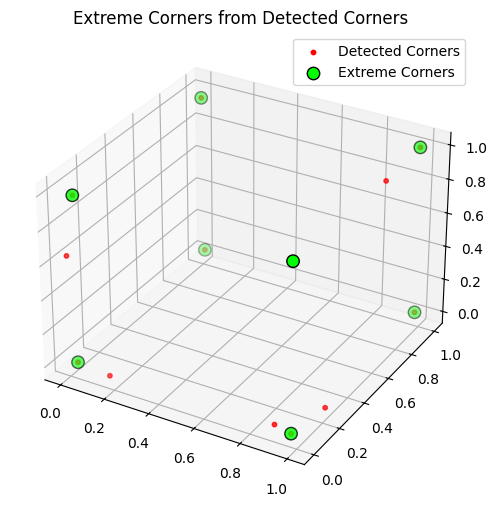

CPU times: user 446 ms, sys: 4.74 ms, total: 451 ms
Wall time: 457 ms


In [14]:
%%time
corners = detect_harris_corners(
    edges,
    normal_k=20,
    radius=0.05,
    k=0.04,
    min_neighbors=10,
    thresh=0.01,
    non_max_radius=0.05
)
print("Detected corners:", len(corners))
extreme_corners = find_extreme_corners(corners)
print("8 extreme corners found:\n", extreme_corners)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(corners[:, 0], corners[:, 1], corners[:, 2], c='red', s=10, label='Detected Corners')
ax.scatter(extreme_corners[:, 0], extreme_corners[:, 1], extreme_corners[:, 2], c='lime', s=80, label='Extreme Corners', edgecolors='k')
ax.legend()
ax.set_title('Extreme Corners from Detected Corners')
plt.show()

## 3. Pose Estimation

In [15]:
%%time
def estimate_pose_from_corners(corners: np.ndarray, dims: tuple, eps: float = 1e-6):
    coords = np.asarray(corners)

    key = coords[:,0] + coords[:,1] - coords[:,2]
    idx1 = np.argmin(key); p1 = coords[idx1]

    mask_x = np.isclose(coords[:,1], p1[1], atol=eps) & np.isclose(coords[:,2], p1[2], atol=eps)
    p2 = coords[mask_x][np.argmax(coords[mask_x,0])]

    mask_y = np.isclose(coords[:,0], p1[0], atol=eps) & np.isclose(coords[:,2], p1[2], atol=eps)
    p3 = coords[mask_y][np.argmax(coords[mask_y,1])]

    d1 = (p2 - p1)/np.linalg.norm(p2 - p1)
    d2 = (p3 - p1)/np.linalg.norm(p3 - p1)
    t_vec = -p1/np.linalg.norm(p1)
    d3 = np.cross(d1, d2); d3 /= np.linalg.norm(d3)
    if np.dot(d3, t_vec) < 0:
        d2 = -d2; d3 = np.cross(d1, d2); d3 /= np.linalg.norm(d3)
    R = np.column_stack((d1, d2, d3))
    l, b, h = dims
    p1_local = np.array([-l/2, -b/2, h/2])
    t = p1 - R.dot(p1_local)
    return R, t, p1, (d1, d2, d3)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.3 µs


Computed object dimensions (l, b, h): (np.float64(1.0), np.float64(1.0), np.float64(1.0))
Estimated Rotation matrix R:
 [[ 1. -0.  0.]
 [ 0. -1.  0.]
 [ 0. -0. -1.]]
Estimated Translation vector t:
 [ 0.5 -0.5  1.5]


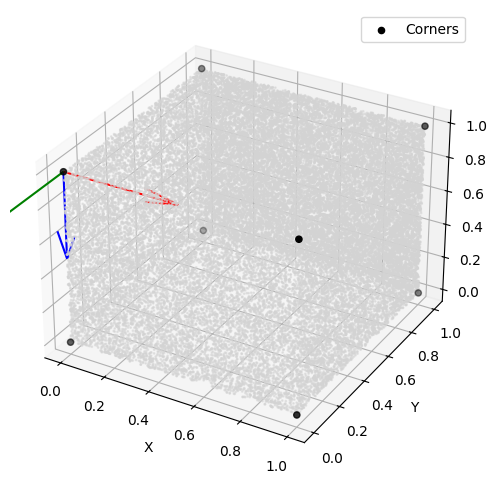

CPU times: user 2.18 s, sys: 11.7 ms, total: 2.19 s
Wall time: 2.19 s


In [16]:
%%time
def plot_full_and_pose(full_cloud: PyntCloud, box_corners: np.ndarray, R: np.ndarray, t: np.ndarray, p1: np.ndarray, axes: tuple, dims: tuple):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    xyz_full = np.vstack((full_cloud.points['x'], full_cloud.points['y'], full_cloud.points['z'])).T
    ax.scatter(xyz_full[:,0], xyz_full[:,1], xyz_full[:,2], c='lightgray', s=1, alpha=0.5)
    ax.scatter(box_corners[:,0], box_corners[:,1], box_corners[:,2], c='k', s=20, label='Corners')
    cols = ['r','g','b']
    for vec, col, length in zip(axes, cols, dims):
        ax.quiver(p1[0], p1[1], p1[2], vec[0], vec[1], vec[2], length=length*0.5, normalize=True, color=col)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend()
    plt.show()

xyz = np.vstack((edges.points['x'], edges.points['y'], edges.points['z'])).T
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(xyz)
aabb = pcd_o3d.get_axis_aligned_bounding_box()
box_corners = np.asarray(aabb.get_box_points())
dims = tuple(aabb.get_extent())
print(f"Computed object dimensions (l, b, h): {dims}")

R, t, p1, axes_vecs = estimate_pose_from_corners(box_corners, dims)
print('Estimated Rotation matrix R:\n', R)
print('Estimated Translation vector t:\n', t)

plot_full_and_pose(full_cloud, box_corners, R, t, p1, axes_vecs, dims)

**Developed By**

* Isha Jangir (202211031)

* Siddarth Nimbalkar (202211057)

* Rajat Kumar Thakur (202211070)